<IPython.core.display.Javascript object>


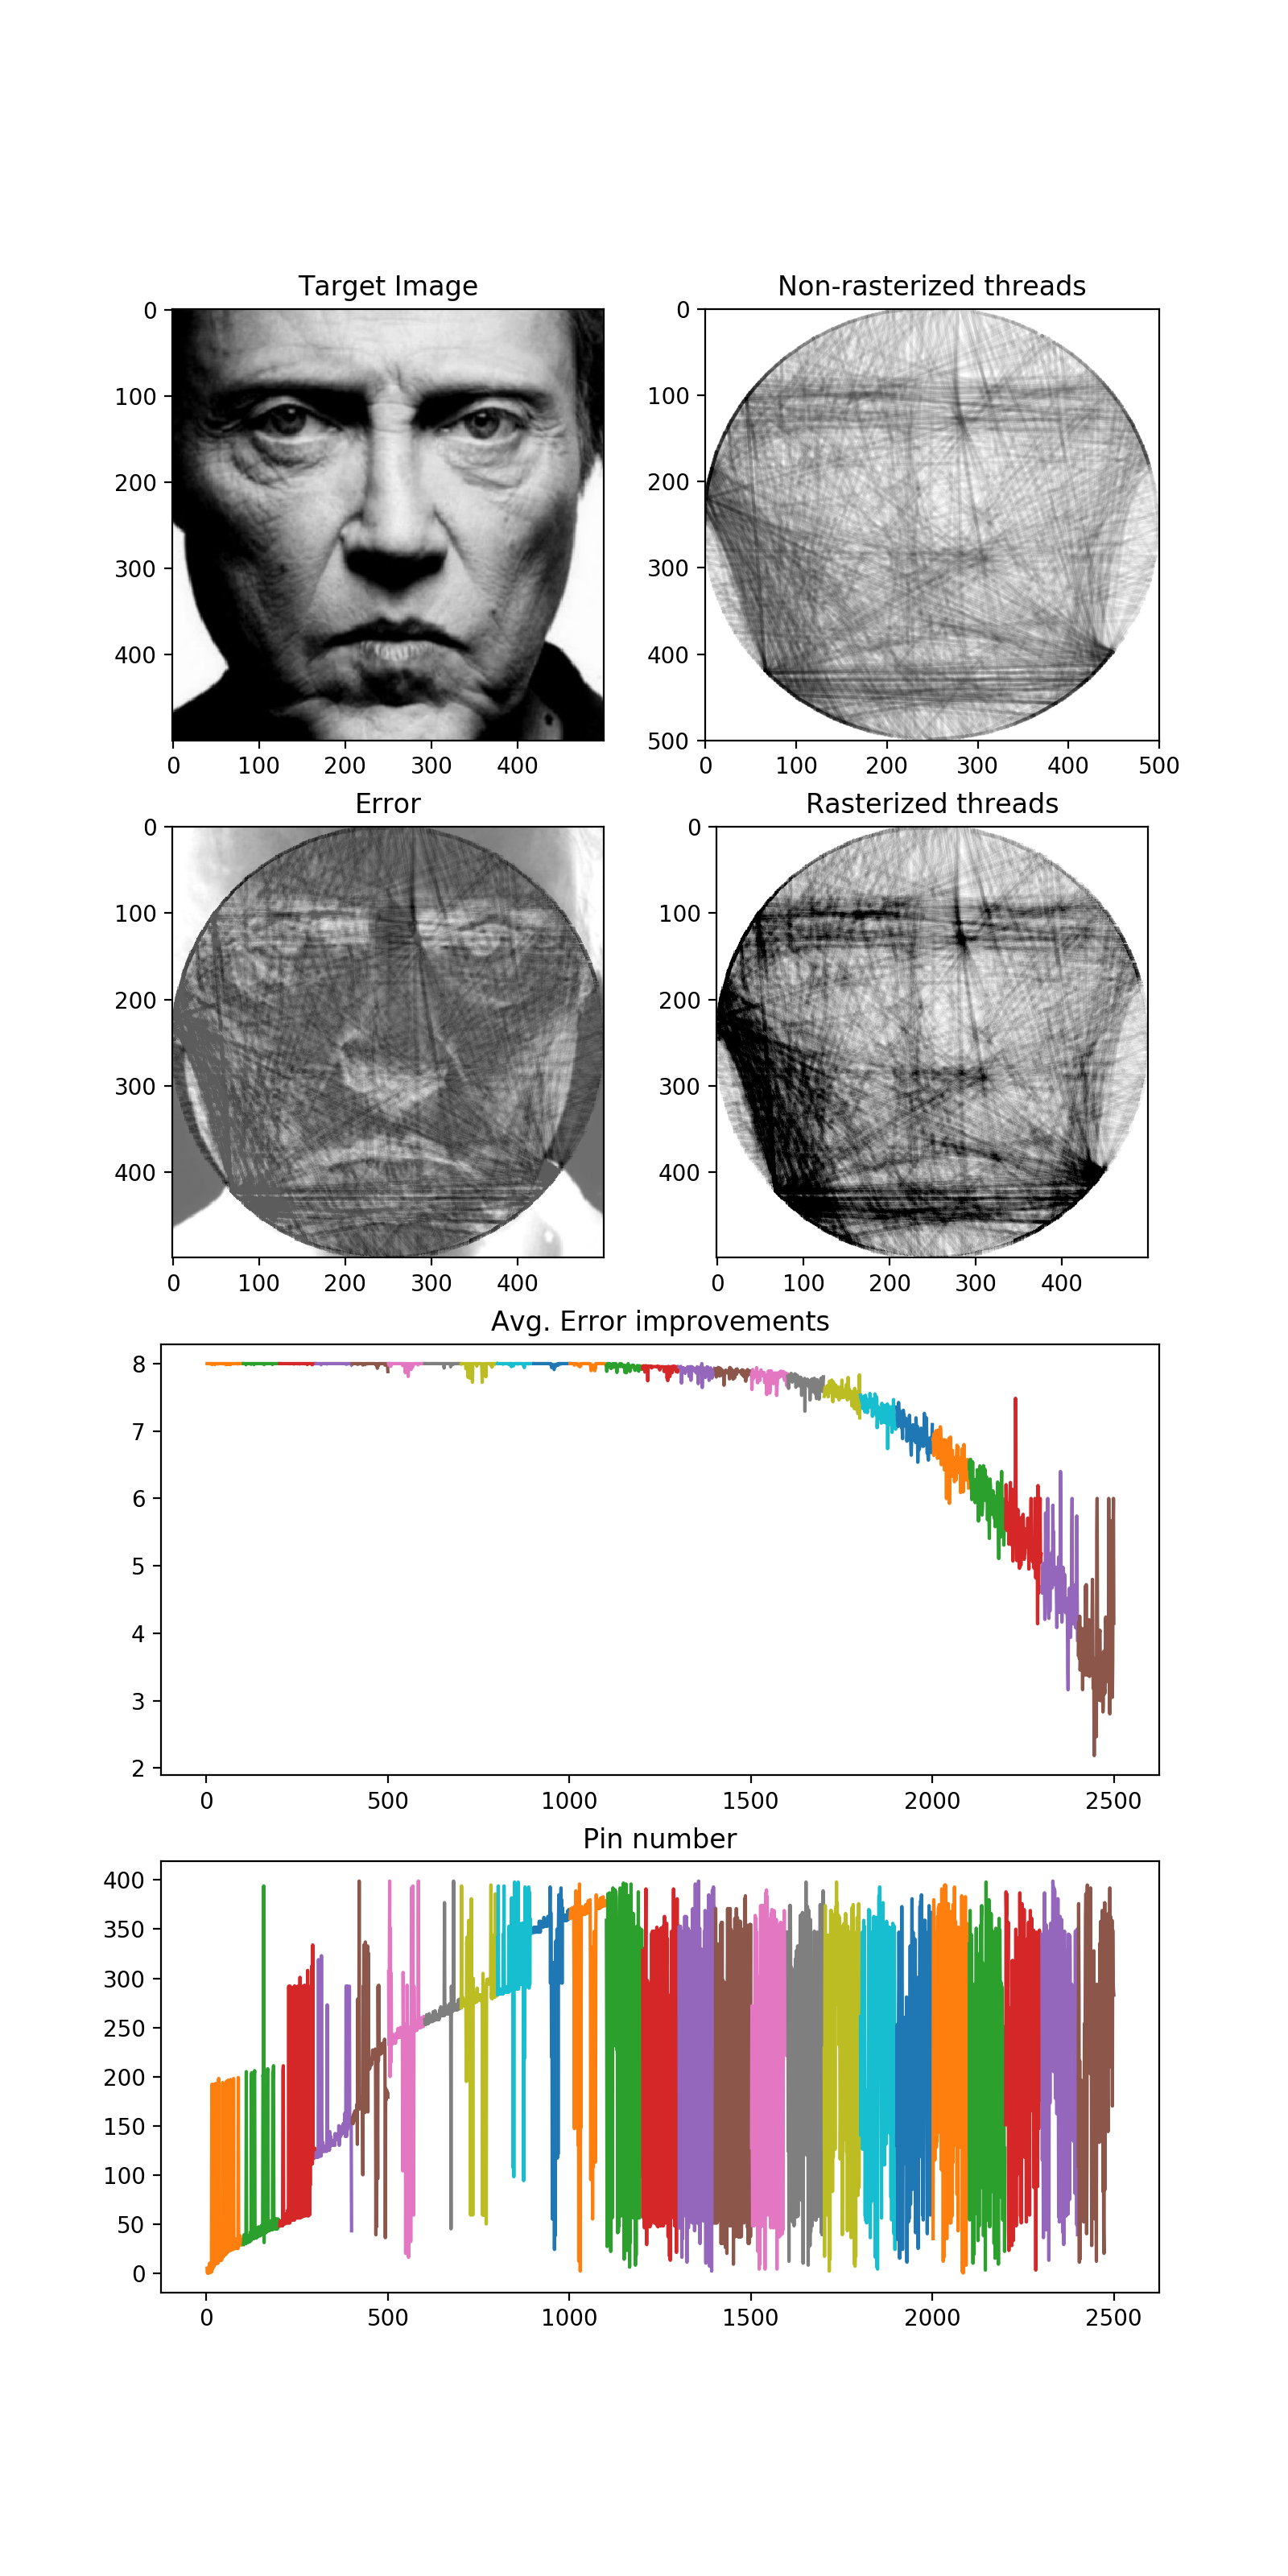

Finished! We drew 2592 lines


In [64]:
import matplotlib.image as mpimg
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from bresenham import bresenham
from scipy import ndimage
from scipy.misc import imresize
from random import randint

%matplotlib nbagg
matplotlib.rcParams['figure.figsize'] = (16,8)

edge_size = 500
line_opacity = 8
num_points = 400
padding = 5
stopping_lookback = 10

# Circle Points
theta = np.linspace(0, 2*np.pi, num_points)
a, b = edge_size * (np.cos(theta)+1)/2-1, edge_size * (np.sin(theta)+1)/2-1
points = zip([int(i) for i in a],[int(i) for i in b])

def get_image(f='./nerea1.jpg'):
    img = ndimage.imread(f, flatten=True)
    return img

class Plot():
    def __init__(self):
        self.fig = plt.figure()#figsize=(8, 16))
        

        self.ax1 = plt.subplot2grid((4, 2), (0, 0))
        self.ax1.set_title("Target Image")
        self.ax2 = plt.subplot2grid((4, 2), (0, 1))
        self.ax2.set_title("Non-rasterized threads")
        self.ax2.set_xlim([0, edge_size])
        self.ax2.set_ylim([edge_size, 0])
        self.ax3 = plt.subplot2grid((4, 2), (1, 1))
        self.ax3.set_title("Rasterized threads")
        self.ax4 = plt.subplot2grid((4, 2), (1, 0))
        self.last_line = 0
        self.ax4.set_title("Error")
        self.ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2)
        self.ax5.set_title("Error improvement")
        self.ax6 = plt.subplot2grid((4, 2), (3, 0), colspan=2)
        self.ax6.set_title("Pin number")
        #self.fig.subplots(figsize=(20, 10))
        #plt.tight_layout()

    def show(self, img, raster, diff, points_log,errors, pins):
        self.ax1.imshow(img, cmap="gray")
        #lc = LineCollection([points_log[-1]], linewidths=2, alpha=0.01)
        #self.ax2.add_collection(lc)
        for i in xrange(self.last_line, len(points_log)-1):
            line_x = [points[points_log[i]][0], points[points_log[i+1]][0]]
            line_y = [points[points_log[i]][1], points[points_log[i+1]][1]]
            self.ax2.plot(line_y, line_x, alpha=float(line_opacity)/255, color="k")
        #self.ax2.plot(*zip(*points), 'b.')
        self.ax3.imshow(raster, cmap="gray")
        self.ax4.imshow(diff, cmap="gray")
        self.fig.canvas.draw()
        self.ax5.plot(range(self.last_line,len(points_log)-1),errors[self.last_line:])
        self.ax6.plot(range(self.last_line,len(points_log)-1),pins[self.last_line:-1])        
        self.last_line = len(points_log)
    
        
        
def get_next_point(prev,diff):
    best_score = -100
    starting_point =  points[prev[-1]]
    for i, proposed_point in enumerate(points):
        if (prev[-1]-i)%num_points < padding or (prev[-1]-i)%num_points > num_points - padding: continue        
        #if (len(prev)>1 and prev[-2]==i): continue
        proposed_line = get_line_pixels(starting_point,proposed_point,thickness = 1)
        score = 0
        for point in proposed_line:
            if diff[point]<line_opacity:
                score = score + diff[point]
            else: 
                score = score + line_opacity
        if float(score)/len(proposed_line)>best_score:
            best_i=i
            best_score = float(score) / len(proposed_line)
    #print best_i
    return best_i, best_score

def get_line_pixels(p1,p2,thickness = 5):
    line_points = []
    line_px = list(bresenham(p1[0], p1[1], p2[0], p2[1]))
    for px in line_px:
        if abs(p1[0]-p2[0])>abs(p1[1]-p2[1]):
            for j in xrange(thickness):
                if px[1]+j>=edge_size:
                    break
                line_points.append((px[0],px[1]+j))
        else:
            for j in xrange(thickness):
                if px[0]+j>=edge_size:
                    break
                line_points.append((px[0]+j,px[1]))
    return line_points

def draw_line(img,pixels):
    for pixel in pixels:
        img[pixel[0],pixel[1]] = max(img[pixel[0],pixel[1]] - line_opacity,0)

def update_diff(diff, raster, img, pixels):
    for pixel in pixels:
        diff[pixel] = raster[pixel] - img[pixel]
    
def main():
    img = get_image('/Users/delbalso/Downloads/chris2.jpg')
    img = imresize((img - img.min())/img.max()*255,(edge_size, edge_size))
    p = Plot()
    
    # Raster is the image we're drawing to simulate thread
    raster = np.zeros((edge_size, edge_size))+255
    assert raster.shape == img.shape
    i = 0
    diff = np.subtract(raster, img)
    errors = []
    points_log = [randint(0, len(points)-1)]
    while (len(errors)<stopping_lookback or 
           sum(errors[-stopping_lookback:]) > stopping_lookback*line_opacity/4):
        next_point, err = get_next_point(points_log[-1:],diff)
        points_log.append(next_point)
        errors.append(err)
        
        line_pixels = get_line_pixels(points[points_log[-2]],points[points_log[-1]])
        draw_line(raster,line_pixels)
        update_diff(diff, raster, img, line_pixels)
        
        if i%100==0: p.show(img,raster,diff,points_log, errors, points_log) 
        i = i+1


    print "Finished! We drew {0} lines".format(i)

if __name__ == "__main__":
    main()